In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
from concurrent.futures import ThreadPoolExecutor
import os
from matplotlib import pyplot as plt
from data_generation import *
import glob

from algorithms import OMP

In [6]:
N = 1000
d = 400
m = 40
noise_level_lst = [0, 0.01, 0.05, 0.1, 0.2, 0.5]
cv_num = 5
seed = 10

In [7]:
data_lst = []

for noise_level in noise_level_lst:
    Data_Geneartor = GaussianDataGenerator(N, d, m, noise_level, seed)
    true_signal, dictionary, true_indices, true_coefficients, perturbed_signal = Data_Geneartor.shuffle()
    data_lst.append((true_signal, dictionary, true_indices, true_coefficients, perturbed_signal))

In [8]:
# Fit omp models with different K to the data and check if it overfits

from algorithms import orthogonal_matching_pursuit

K_lst = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

results = []

for i, noise_level in enumerate(noise_level_lst):
    true_signal, dictionary, true_indices, true_coefficients, perturbed_signal = data_lst[i]
    noise_level_K_results = []
    for K in K_lst:
        a, _, coefficients = orthogonal_matching_pursuit(perturbed_signal, dictionary, K)
        MSE = np.mean((a - true_signal)**2)
        noise_level_K_results.append(MSE)
    results.append(noise_level_K_results)


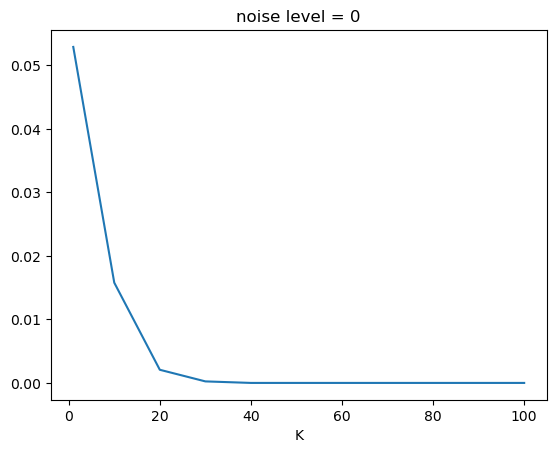

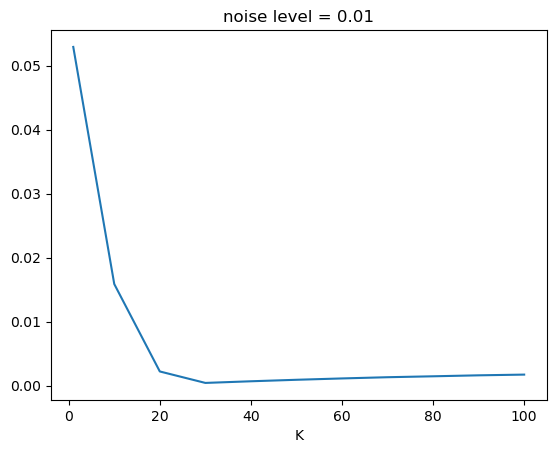

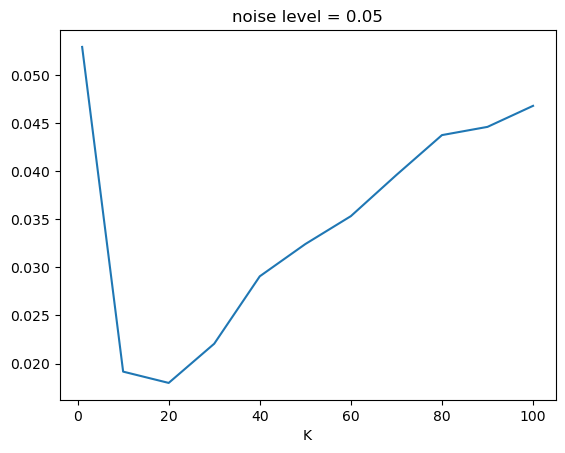

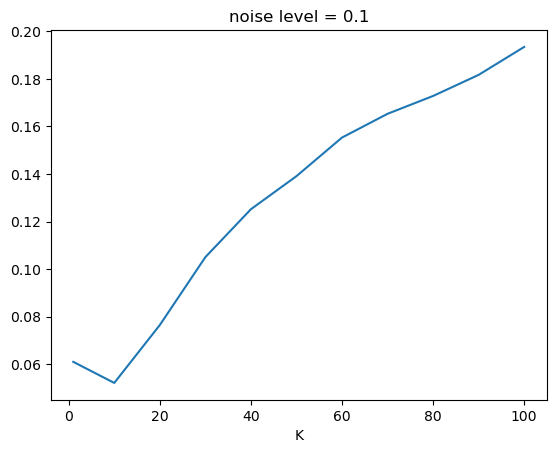

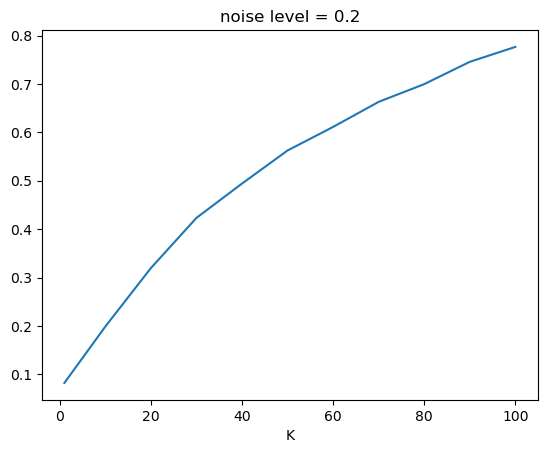

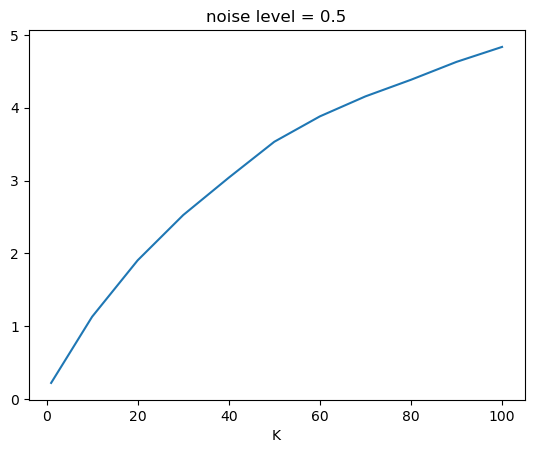

In [9]:
# Visualize the results

for i, noise_level in enumerate(noise_level_lst):
    plt.subplots()
    plt.title(f'noise level = {noise_level}')
    plt.plot(K_lst, results[i], label=f'noise level = {noise_level}')
    plt.xlabel('K')
    plt.show()

In [10]:
results2 = []

for i, noise_level in enumerate(noise_level_lst):
    true_signal, dictionary, true_indices, true_coefficients, perturbed_signal = data_lst[i]
    noise_level_K_results = []
    for K in K_lst:
        OMP_tmp = OMP(K=K, random_seed=seed)
        OMP_tmp.fit(perturbed_signal, dictionary)
        mse_tmp = OMP_tmp.score(s_test = true_signal, phi_test = dictionary)
        noise_level_K_results.append(mse_tmp)
    results2.append(noise_level_K_results)

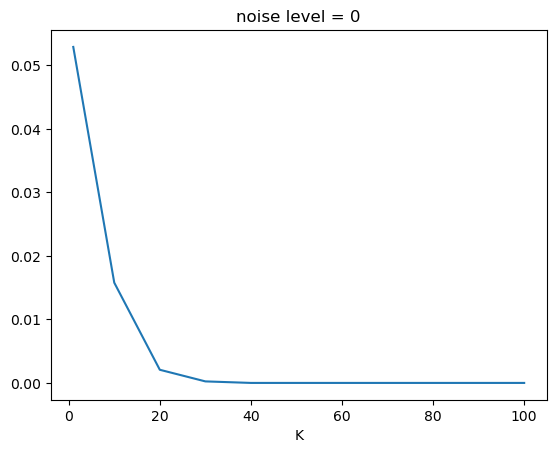

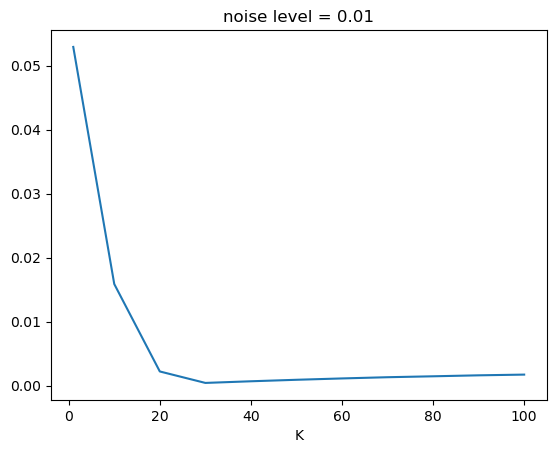

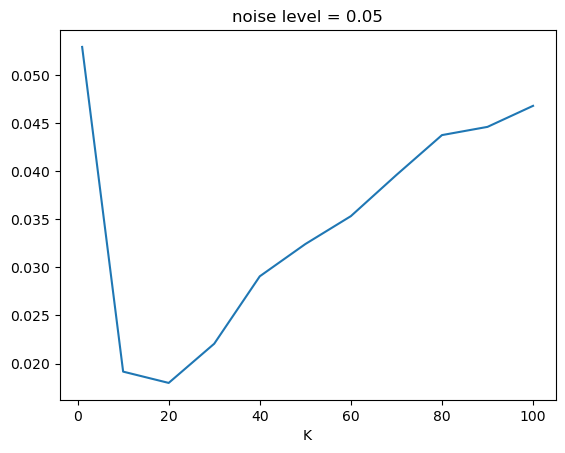

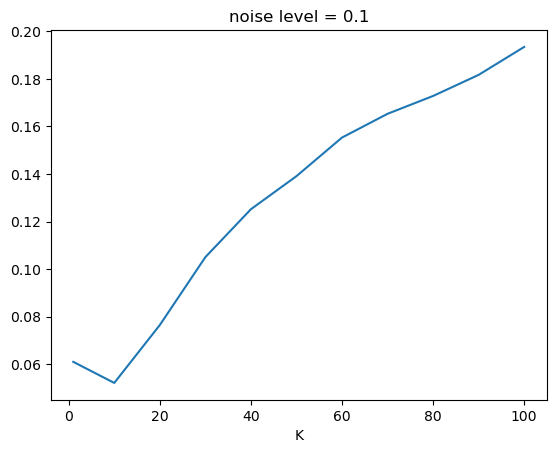

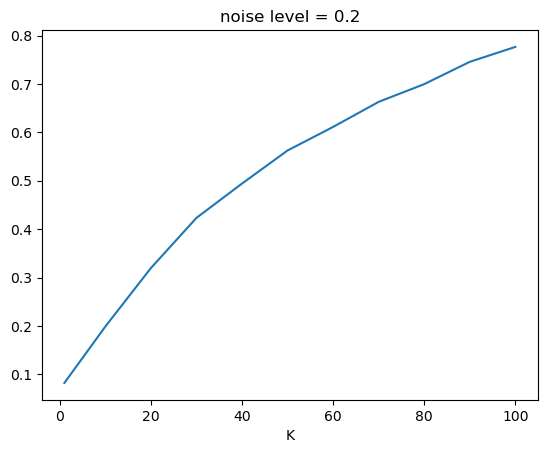

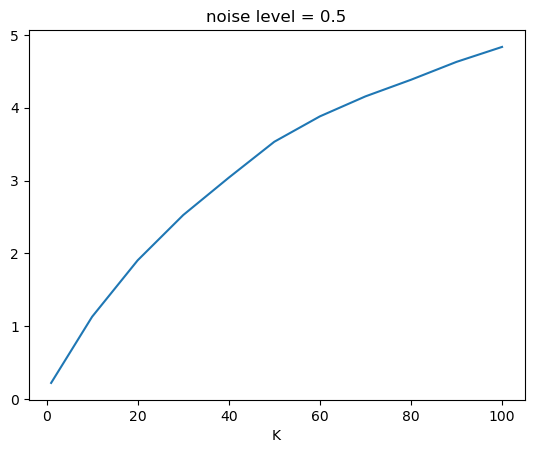

In [11]:
# Visualize the results

for i, noise_level in enumerate(noise_level_lst):
    plt.subplots()
    plt.title(f'noise level = {noise_level}')
    plt.plot(K_lst, results[i], label=f'noise level = {noise_level}')
    plt.xlabel('K')
    plt.show()

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import warnings 

warnings.filterwarnings('ignore')

num_trials = 20
noise_level_lst = [0.1, 0.2, 0.3, 0.4, 0.5]
cv_num = 5

for noise_level in noise_level_lst:
    print(f'Cross validating under noise level {noise_level}')
    noise_level_res = []
    for trial in range(num_trials):
        print(f'Running trial {trial}')
        Data_Geneartor = GaussianDataGenerator(N, d, m, noise_level, trial)
        true_signal, dictionary, true_indices, true_coefficients, perturbed_signal = Data_Geneartor.shuffle()
        # Cross validation hyperparameter tuning
        rf = RandomForestRegressor(random_state=trial)
        param_grid = {
            'n_estimators': [100, 200, 500],
            'max_depth': [10, 50, 100],
            'min_samples_split': [2, 10, 50],
            'min_samples_leaf': [1, 5, 10],
            'max_features': ['sqrt', 'log2', 0.5] 
        }
        gs = GridSearchCV(rf, param_grid, cv=cv_num, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')
        gs.fit(dictionary, perturbed_signal.ravel())
        best_params = gs.best_params_
        lowest_mse = - gs.best_score_
        noise_level_res.append(lowest_mse)
        print("Trial: ", trial, " Best params: ", best_params, " Lowest Error: ", lowest_mse)
    print(f'For noise level {noise_level}, the average MSE is {np.mean(noise_level_res)}')
    


Cross validating under noise level 0.1
Running trial 0
Fitting 5 folds for each of 21504 candidates, totalling 107520 fits


KeyboardInterrupt: 